# Predictive Maintenance using Machine Learning on Sagemaker
*Part 4 - Hyperparameter tuning*

## Initialization
---
Directory structure to run this notebook:
```
sagemaker-predictive-maintenance
|
+--- data
|   |
|   +--- interim: intermediate data we can manipulate and process
|   |
|   \--- raw: *immutable* data downloaded from the source website
|
+--- notebooks: all the notebooks are positionned here
```

### Imports

In [3]:
import matplotlib.pyplot as plt
import time
import sagemaker
import boto3
import seaborn as sns
import pandas as pd

from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import RealTimePredictor, csv_serializer, csv_deserializer

from datetime import datetime
from sklearn.externals import joblib

sns.set_style('darkgrid')

In [4]:
!pip install tabulate
import tabulate

You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### Loading data from the previous notebook

In [5]:
%store -r

# If the data are not present in the notebook local storage, we need to load them from disk:
success_msg = 'Loaded "test_data_scaled", "reg_results_df" and "cls_results_df"'
if 'test_data_scaled' not in locals():
    try:
        local_path = '../data/interim'
        test_data_scaled = pd.read_csv(os.path.join(local_path, 'test_data_scaled.csv'))
        reg_results_df = pd.read_csv(os.path.join(local_path, 'reg_results_df.csv'))
        cls_results_df = pd.read_csv(os.path.join(local_path, 'cls_results_df.csv'))
            
        print(success_msg)
            
    except Exception as e:
        if (e.errno == errno.ENOENT):
            print('Files not found to load data from: you need to execute the previous notebook.')
            
else:
    print(success_msg)

Loaded "test_data_scaled", "reg_results_df" and "cls_results_df"


### Set general information about this SageMaker session

In [6]:
role = sagemaker.get_execution_role()
session = sagemaker.Session()
bucket_name = session.default_bucket()
region = boto3.Session().region_name
prefix = 'nasa_engine_data'

## Hyperparameter tuning job
---
### Optimizing the classification model
#### Defining the model and the tuning job

> # ### TO DO ###

### Optimizing the regression model
#### Defining the model and the tuning job
Before launching a tuning job, we need to define the base Estimator object that will be used. This is similar to the Estimator object created during a single training occurrence:

In [7]:
# Fetch the training container for SageMaker built-in XGBoost algorithm:
xgb_container = get_image_uri(region, 'xgboost', '0.90-1')

# Build a training job name:
training_job_name = 'xgboost-nasa-rul-reg'

# Build the estimator object:
model_artifacts_path = 's3://{}/{}/output'.format(bucket_name, prefix)
xgb_regression_estimator = sagemaker.estimator.Estimator(
    image_name=xgb_container,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.m5.large',
    output_path=model_artifacts_path,
    sagemaker_session=session,
    base_job_name=training_job_name
)

# Link hyperparameters to this estimator:
xgb_regression_estimator.set_hyperparameters(
    max_depth=6,                   # Max depth of a given tree
    eta=0.3,                       # Step size shrinkage used in updates to prevent overfitting
    gamma=0,                       # Minimum loss reduction required to make a further partition on a leaf node of the tree
    min_child_weight=1,            # Minimum sum of instance weight (hessian) needed in a child
    subsample=1.0,                 # Subsample ratio of the training instance
    silent=0,                      # 0 means print running messages
    objective='reg:squarederror',  # Learning task and learning objective
    num_round=40                   # The number of rounds to run the training
)

Now we need to define the hyperparameters tuning job exploration ranges. You can refer yourself to [this page](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost-tuning.html) to understand the different metrics computed by the XGBoost algorithm and the associated optimization direction:

In [8]:
from sagemaker.tuner import HyperparameterTuner, IntegerParameter, ContinuousParameter

xgb_regression_tuner = HyperparameterTuner(
    estimator = xgb_regression_estimator,         # The estimator object to use as the basis for the training jobs.
    objective_metric_name = 'validation:rmse',    # The metric used to compare trained models (RMSE in this case).
    objective_type = 'Minimize',                  # We wish to minimize this error metric.
    max_jobs = 10,                                # The total number of models to train
    max_parallel_jobs = 2,                        # The number of models to train in parallel
    hyperparameter_ranges = {
        'max_depth': IntegerParameter(3, 10),
        'eta': ContinuousParameter(0.01, 0.3),
        'gamma': ContinuousParameter(0, 10),
        'subsample': ContinuousParameter(0.5, 1.0),
        'colsample_bytree': ContinuousParameter(0.5, 1.0)
    },
    base_tuning_job_name = training_job_name + '-tuner'
)

We still need to encapsulate the inputs in S3 objects to make sure content type is correctly identified by the algorithm:

In [9]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/input/training_regression.csv'.format(bucket_name, prefix), content_type='text/csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/input/validation_regression.csv'.format(bucket_name, prefix), content_type='text/csv')

We can now launch the hyperparameter job by training the tuner created previously. Note that by default the command gives back control to the notebook and does not wait for the tuning job to be finished.

In [14]:
xgb_regression_tuner.fit(inputs={'train': s3_input_train, 'validation': s3_input_validation}, logs=True)

The following cell illustrates how to follow what is going on in the background. It provides similar insights than what can be visible in the AWS Console for the SageMaker Hyperparameter Tuning Jobs section:

In [16]:
from IPython.display import clear_output
import time
import tabulate

# Get a description of the current tuning job:
utils.get_tuner_status(xgb_regression_tuner._current_job_name)

Tuning job in progress (status: InProgress)
9 training jobs are complete:
+----+--------------------------------------------+---------------------+-----------------------+-----------+-----------+-------------+-------------+--------------------+---------------------------+
|    | TrainingJobName                            | TrainingJobStatus   |   FinalObjectiveValue |       eta |     gamma |   max_depth |   subsample |   colsample_bytree | TrainingStartTime         |
|----+--------------------------------------------+---------------------+-----------------------+-----------+-----------+-------------+-------------+--------------------+---------------------------|
|  3 | sagemaker-xgboost-200514-1623-007-966f0cad | Completed           |               42.9391 | 0.234323  | 4.92108   |           6 |    0.837986 |           0.84723  | 2020-05-14 16:36:15+00:00 |
|  2 | sagemaker-xgboost-200514-1623-008-fe37c6aa | Completed           |               43.5915 | 0.260873  | 9.08876   |         

#### Deploying an endpoint to query the best model found
Now that the hyperparameter tuning job is finished, we can deploy an endpoint to query the best model found:

In [17]:
endpoint_name = 'xgboost-nasa-regression-v2-{}'.format(datetime.now().strftime("%Y%m%d-%H%M%S"))
print('The following endpoint will be created for the best estimator previously found:', endpoint_name)

# Get the training job descriptor to extract the location of the 
# model artifacts on S3 and the container for the algorithm image:
# Collect the best training job name and associated estimator:
sm_client = boto3.client('sagemaker')
best_xgb_training_job = xgb_regression_tuner.best_training_job()
training_job_description = sm_client.describe_training_job(TrainingJobName=best_xgb_training_job)
model_artifacts = training_job_description['ModelArtifacts']['S3ModelArtifacts']
training_image = training_job_description['AlgorithmSpecification']['TrainingImage']

# Create a deployable model:
sm_client.create_model(
    ModelName = endpoint_name + '-model',
    ExecutionRoleArn = role,
    PrimaryContainer = {
        'Image': training_image,
        'ModelDataUrl': model_artifacts
    }
)

# Creates the endpoint configuration: this entity describes the distribution of traffic 
# across the models, whether split, shadowed, or sampled in some way:
sm_client.create_endpoint_config(
    EndpointConfigName = endpoint_name + '-endpoint-cfg',
    ProductionVariants=[{
        'InstanceType': 'ml.t2.medium',
        'InitialVariantWeight': 1,
        'InitialInstanceCount': 1,
        'ModelName': endpoint_name + '-model',
        'VariantName':'AllTraffic'
    }]
)

# Creates the endpoint: this entity serves up the model, through 
# specifying the name and configuration defined above:
xgb_regression_predictor = sm_client.create_endpoint(
    EndpointName = endpoint_name,
    EndpointConfigName = endpoint_name + '-endpoint-cfg'
)

The following endpoint will be created for the best estimator previously found: xgboost-nasa-regression-v2-20200514-164238


Let's wait for the endpoint to be created:

In [18]:
status = sm_client.describe_endpoint(EndpointName=endpoint_name)['EndpointStatus']
print('Endpoint creation in progress... ', end='')
while status == 'Creating':
    time.sleep(60)
    print('#', end='')
    status = sm_client.describe_endpoint(EndpointName=endpoint_name)['EndpointStatus']
    
if (status == 'InService'):
    print('\nEndpoint creation successful.')
    
    # Build a predictor object which will receive our prediction requests:
    xgb_regression_predictor = RealTimePredictor(
        endpoint = endpoint_name,
        sagemaker_session = session,
        serializer = csv_serializer,
        deserializer = csv_deserializer
    )
    
else:
    print('\nEndpoint creation failed.')

Endpoint creation in progress...
Endpoint creation in progress...
Endpoint creation in progress...
Endpoint creation in progress...
Endpoint creation in progress...
Endpoint creation in progress...
Endpoint creation in progress...
Endpoint creation in progress...
Endpoint creation successful.


#### Get prediction for the test data

In [19]:
# We want to estimate the remaining useful lifetime for each unit:
tuned_reg_results_df = pd.DataFrame(columns=['unit_number', 'real_rul', 'predicted_rul'])

# Loops through each unit:
for i in range(0, 100):
    # Get all the test data for the current unit:
    row = test_data_scaled[test_data_scaled['unit_number'] == (i+1)].iloc[-1, :]
    
    # Join them together into a list before sending them to the predictor:
    test_sample = ', '.join(row[X_train.columns].map(str).tolist())
    prediction = xgb_regression_predictor.predict(test_sample)
    
    # Add the result for the current unit to the results dataframe:
    tuned_reg_results_df = tuned_reg_results_df.append({
        'unit_number': (i+1),
        'real_rul': row['rul'],
        'predicted_rul': float(prediction[0][0])
    }, ignore_index=True)
    
tuned_reg_results_df = tuned_reg_results_df.set_index('unit_number')
tuned_reg_results_df.head()

,real_rul,predicted_rul
unit_number,,
1.0,112.0,154.593552
2.0,98.0,129.266235
3.0,69.0,61.693615
4.0,82.0,95.877014
5.0,91.0,116.271301


We can use the following dataframe to perform some error analysis:

In [20]:
df = pd.merge(reg_results_df, tuned_reg_results_df, how='inner', left_index=True, right_index=True)
df = df[['real_rul_x', 'predicted_rul_y', 'predicted_rul_x']]
df.columns = ['Real RUL', 'Initial Prediction', 'After HP Tuning']
df.head(10)

,Real RUL,Initial Prediction,After HP Tuning
unit_number,,,
1.0,112.0,154.593552,147.754944
2.0,98.0,129.266235,126.293488
3.0,69.0,61.693615,59.875839
4.0,82.0,95.877014,111.328903
5.0,91.0,116.271301,106.703590
6.0,93.0,128.255066,74.711128
7.0,91.0,105.454819,115.125412
8.0,95.0,103.107292,77.082909
9.0,111.0,114.027756,121.945366


In [21]:
from sklearn.metrics import r2_score

print('R² (initial):', r2_score(reg_results_df['real_rul'], reg_results_df['predicted_rul']))
print('R² (after hyperparameter tuning):', r2_score(tuned_reg_results_df['real_rul'], tuned_reg_results_df['predicted_rul']))

R² (initial): 0.39705319922447724
R² (after hyperparameter tuning): 0.44298449755454905


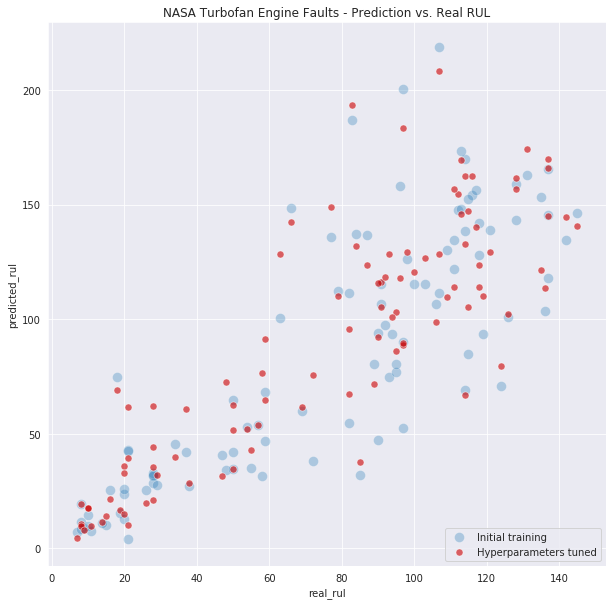

In [22]:
figure=plt.figure(figsize=(10,10))
chart = sns.scatterplot(x=reg_results_df['real_rul'], y=reg_results_df['predicted_rul'], s=100, alpha=0.3, label='Initial training');
chart = sns.scatterplot(x=tuned_reg_results_df['real_rul'], y=tuned_reg_results_df['predicted_rul'], s=50, alpha=0.6, color='#CC0000', label='Hyperparameters tuned');
chart.set_title('NASA Turbofan Engine Faults - Prediction vs. Real RUL');
chart.legend(loc='lower right');

## Conclusion
---
Although the R² almost doubled from the initial training, we are still very far from a usable model in production. In the next series of Notebook, we will consider timeseries analysis.
### Cleanup

In [23]:
sm_client.delete_endpoint(EndpointName=endpoint_name);
sm_client.delete_endpoint_config(EndpointConfigName=endpoint_name + '-endpoint-cfg');
sm_client.delete_model(ModelName=endpoint_name + '-model');